# ハミルトニアンモンテカルロ（HMC）法

**ハミルトニアンモンテカルロ（Hamiltonian Monte Carlo: HMC）法** は、ハミルトニアン力学（古典力学）のシミュレーション手法をMCMCに応用したアルゴリズムである。事後分布の勾配（対数密度の勾配）を利用して効率的にサンプリングする。

- 元々は **Hybrid Monte Carlo** と呼ばれていた（Duane et al., 1987）。格子QCDの計算のために開発された
- Neal (2011) が統計学向けに整理し、現在ではStan、PyMC、NumPyroなどの主要なベイズ推定フレームワークの核となっている

## MH法の問題点とHMCの動機

メトロポリス・ヘイスティング（MH）法のランダムウォーク提案には、次の構造的な問題がある：

1. **提案の方向がランダム**: 提案 $\theta' = \theta + \varepsilon,\; \varepsilon \sim \mathcal{N}(0, s^2 I)$ は事後分布の形状を無視しているため、密度の低い方向へも同じ確率で提案してしまう
2. **ステップサイズのジレンマ**: 小さいと受理率は高いが探索が遅く、大きいと棄却されやすくなる
3. **高次元での性能劣化**: 次元が上がると受理率が急激に低下し、実用的な時間で収束しなくなる

HMCは、事後分布の **勾配情報** を使って、密度の高い方向へ提案を導くことでこれらの問題を解決する。

## ハミルトニアン力学のアナロジー

HMCは、古典力学における **ハミルトニアン力学** とのアナロジーで構成されている。

| 古典力学 | MCMCにおける対応 |
|----------|----------------------|
| 位置 $q$ | パラメータ $\theta$ |
| 運動量 $p$ | 補助変数（ランダムに導入） |
| ポテンシャルエネルギー $U(q)$ | 負の対数事後分布 $-\log p(\theta \mid y)$ |
| 運動エネルギー $K(p)$ | $\frac{1}{2} p^\top M^{-1} p$ |
| ハミルトニアン $H(q, p)$ | $U(q) + K(p)$ |

**ハミルトニアン**（全エネルギー）はポテンシャルエネルギーと運動エネルギーの和として定義される：

$$
H(\theta, p) = U(\theta) + K(p) = -\log p(\theta \mid y) + \frac{1}{2} p^\top M^{-1} p
$$

ここで $M$ は質量行列（mass matrix）であり、通常は単位行列や対角行列が使われる。

ハミルトンの運動方程式は

$$
\frac{d\theta}{dt} = \frac{\partial H}{\partial p} = M^{-1} p, \qquad
\frac{dp}{dt} = -\frac{\partial H}{\partial \theta} = -\nabla_\theta U(\theta) = \nabla_\theta \log p(\theta \mid y)
$$

であり、運動量 $p$ の更新に事後分布の対数密度の勾配 $\nabla_\theta \log p(\theta \mid y)$ が使われる。これが「密度の高い方向へ導かれる」仕組みである。

### ハミルトニアン力学の重要な性質

HMCの正当性は、ハミルトニアン力学の以下の性質に基づいている：

**1. エネルギー保存**

ハミルトンの運動方程式に正確に従えば、$H(\theta, p)$ は時間発展を通じて保存される。すなわち

$$
H(\theta(t), p(t)) = H(\theta(0), p(0)) \quad \forall t
$$

これにより、ハミルトニアン力学に従って提案された点はMH法の受理確率が常に1になる（後述の数値積分による誤差を除けば）。

**2. 体積保存（シンプレクティック性）**

ハミルトニアンの時間発展は体積を保存する：

$$
\left| \det \frac{\partial (\theta', p')}{\partial (\theta, p)} \right| = 1
$$

これにより、MH法の受理確率におけるヤコビアンの補正項が不要になる。

**3. 可逆性（時間反転対称性）**

$p \to -p$ の変換で時間発展が反転する。この性質は詳細つり合い条件の保証に使われる。

## リープフロッグ積分法

ハミルトンの運動方程式は一般に解析的に解けないため、数値積分で近似する。HMCでは **リープフロッグ（leapfrog）積分法** が使われる。

ステップサイズ $\varepsilon$ で $L$ ステップ分の時間発展を行う：

:::{admonition} リープフロッグ積分法

**1. 運動量の半ステップ更新**

$$
p \leftarrow p - \frac{\varepsilon}{2} \nabla_\theta U(\theta)
$$

**2. 位置の全ステップ更新**

$$
\theta \leftarrow \theta + \varepsilon\, M^{-1} p
$$

**3. ステップ2-1を $L-1$ 回繰り返す**

**4. 運動量の最後の半ステップ更新**

$$
p \leftarrow p - \frac{\varepsilon}{2} \nabla_\theta U(\theta)
$$

:::

リープフロッグ積分は以下の性質を持ち、HMCの正当性を保証する：

- **可逆性**: $p \to -p$ とすれば元の状態に戻る
- **体積保存**: ヤコビアンの行列式が1
- **エネルギー近似保存**: $\varepsilon$ が小さいほど、$H$ の変化が小さい（誤差は $O(\varepsilon^3)$ オーダー）

なお、オイラー法や修正オイラー法では体積保存性が崩れるため、リープフロッグが選ばれる。

## HMCアルゴリズム

:::{admonition} Hamiltonian Monte Carlo アルゴリズム

**初期値** $\theta^{(0)}$ を選ぶ。

$t = 1, \dots, T$ について以下を繰り返す：

**1. 運動量のサンプリング**

$$
p \sim \mathcal{N}(0, M)
$$

**2. リープフロッグ積分**

現在の $(\theta^{(t)}, p)$ からリープフロッグ $L$ ステップを実行し、提案状態 $(\theta', p')$ を得る。

**3. MHの受理・棄却**

受理確率を計算する：

$$
r = \min\left(1,\; \exp\left(-H(\theta', p') + H(\theta^{(t)}, p)\right)\right)
$$

一様乱数 $u \sim \mathrm{Uniform}(0,1)$ を生成し、

- $u < r$ なら受理: $\theta^{(t+1)} = \theta'$
- それ以外は棄却: $\theta^{(t+1)} = \theta^{(t)}$

:::

エネルギーが完全に保存されれば $H(\theta', p') = H(\theta^{(t)}, p)$ となり $r = 1$ となるが、数値積分の誤差によりわずかに $H$ が変化するため、MHの受理・棄却ステップが必要である。これにより数値誤差があってもサンプリングの正当性が保証される。

## Pythonによる実装

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def leapfrog(
    theta: np.ndarray,
    p: np.ndarray,
    grad_U: callable,
    epsilon: float,
    L: int,
) -> tuple[np.ndarray, np.ndarray]:
    """
    リープフロッグ積分法

    Parameters
    ----------
    theta : np.ndarray
        現在のパラメータ値
    p : np.ndarray
        現在の運動量
    grad_U : callable
        ポテンシャルエネルギーの勾配 (負の対数事後分布の勾配)
    epsilon : float
        ステップサイズ
    L : int
        ステップ数

    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        更新後の (theta, p)
    """
    theta = theta.copy()
    p = p.copy()

    # 運動量の半ステップ
    p -= 0.5 * epsilon * grad_U(theta)

    for i in range(L - 1):
        # 位置の全ステップ
        theta += epsilon * p
        # 運動量の全ステップ
        p -= epsilon * grad_U(theta)

    # 位置の最後の全ステップ
    theta += epsilon * p
    # 運動量の最後の半ステップ
    p -= 0.5 * epsilon * grad_U(theta)

    # 運動量を反転（可逆性のため）
    p = -p

    return theta, p


def hmc(
    U: callable,
    grad_U: callable,
    dim: int,
    n_samples: int = 10_000,
    burn_in: int = 1_000,
    epsilon: float = 0.1,
    L: int = 20,
    init: np.ndarray | None = None,
    seed: int = 42,
) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Hamiltonian Monte Carlo

    Parameters
    ----------
    U : callable
        ポテンシャルエネルギー = -log p(theta | y)
    grad_U : callable
        Uの勾配
    dim : int
        パラメータの次元
    n_samples : int
        サンプル数
    burn_in : int
        バーンイン期間
    epsilon : float
        リープフロッグのステップサイズ
    L : int
        リープフロッグのステップ数
    init : np.ndarray or None
        初期値
    seed : int
        乱数シード

    Returns
    -------
    tuple[np.ndarray, np.ndarray, float]
        (burn-in後のサンプル, 全トレース, 受理率)
    """
    rng = np.random.default_rng(seed)

    if init is None:
        init = np.zeros(dim)

    samples = np.empty((n_samples, dim))
    theta = init.copy()
    accepted = 0

    for t in range(n_samples):
        # 1. 運動量をサンプリング
        p = rng.standard_normal(dim)

        # 現在のハミルトニアン
        current_H = U(theta) + 0.5 * np.dot(p, p)

        # 2. リープフロッグ積分
        theta_prop, p_prop = leapfrog(theta, p, grad_U, epsilon, L)

        # 提案状態のハミルトニアン
        proposed_H = U(theta_prop) + 0.5 * np.dot(p_prop, p_prop)

        # 3. MHの受理・棄却
        log_alpha = current_H - proposed_H
        if np.log(rng.random()) < log_alpha:
            theta = theta_prop
            accepted += 1

        samples[t] = theta

    acc_rate = accepted / n_samples
    posterior = samples[burn_in:]

    return posterior, samples, acc_rate

### 2次元正規分布からのサンプリング

まず簡単な例として、目標分布が2次元正規分布である場合を考える。目標分布を

$$
p(\theta) = \mathcal{N}\left(\theta \;\middle|\; \begin{pmatrix} 0 \\ 0 \end{pmatrix},\; \begin{pmatrix} 1 & 0.8 \\ 0.8 & 1 \end{pmatrix}\right)
$$

とする。正規分布の場合、ポテンシャルエネルギーとその勾配は解析的に求まる：

$$
U(\theta) = \frac{1}{2} \theta^\top \Sigma^{-1} \theta, \qquad
\nabla U(\theta) = \Sigma^{-1} \theta
$$

In [3]:
# 目標分布: 2次元相関のある正規分布
Sigma = np.array([[1.0, 0.8], [0.8, 1.0]])
Sigma_inv = np.linalg.inv(Sigma)


def U_normal(theta):
    return 0.5 * theta @ Sigma_inv @ theta


def grad_U_normal(theta):
    return Sigma_inv @ theta


posterior, trace, acc_rate = hmc(
    U=U_normal,
    grad_U=grad_U_normal,
    dim=2,
    n_samples=5_000,
    burn_in=500,
    epsilon=0.15,
    L=25,
)

print(f"acceptance rate = {acc_rate:.3f}")
print(f"posterior mean  = {posterior.mean(axis=0)}")
print(f"posterior cov   =\n{np.cov(posterior.T)}")

acceptance rate = 0.994
posterior mean  = [ 0.0012916  -0.00399892]
posterior cov   =
[[1.11486393 0.91625932]
 [0.91625932 1.11725158]]


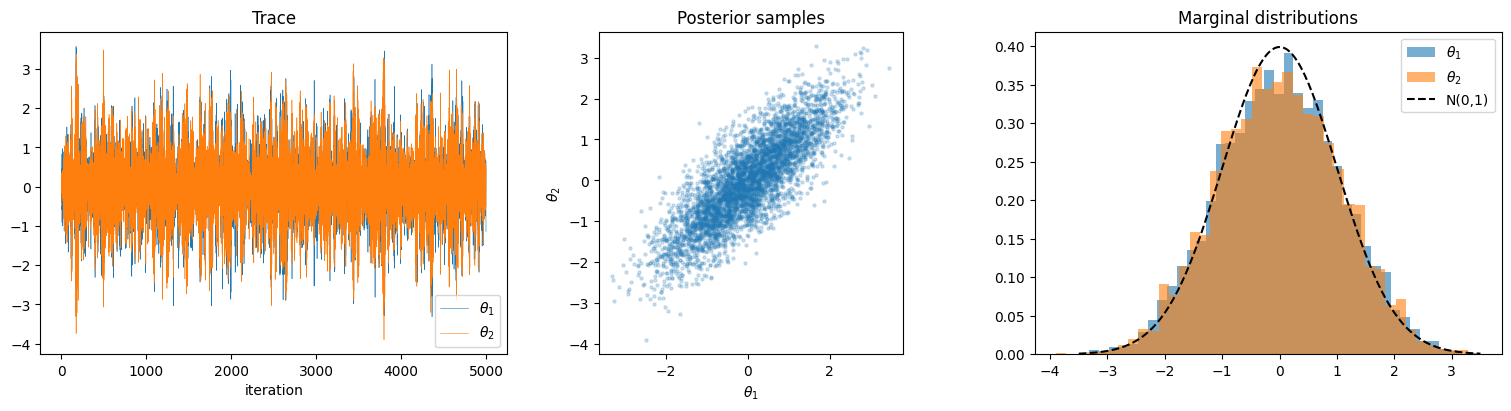

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

# トレースプロット
for i, label in enumerate([r"$\theta_1$", r"$\theta_2$"]):
    axes[0].plot(trace[:, i], linewidth=0.4, label=label)
axes[0].set_title("Trace")
axes[0].set_xlabel("iteration")
axes[0].legend()

# 事後分布の散布図
axes[1].scatter(posterior[:, 0], posterior[:, 1], alpha=0.2, s=5)
axes[1].set_xlabel(r"$\theta_1$")
axes[1].set_ylabel(r"$\theta_2$")
axes[1].set_title("Posterior samples")
axes[1].set_aspect("equal")

# 周辺分布のヒストグラム
axes[2].hist(posterior[:, 0], bins=40, density=True, alpha=0.6, label=r"$\theta_1$")
axes[2].hist(posterior[:, 1], bins=40, density=True, alpha=0.6, label=r"$\theta_2$")
# 理論値
x = np.linspace(-3.5, 3.5, 200)
axes[2].plot(x, 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2), "k--", label="N(0,1)")
axes[2].set_title("Marginal distributions")
axes[2].legend()

plt.show()

### ベイズ線形回帰への適用

より実践的な例として、ベイズ線形回帰モデル

$$
y_i \sim \mathcal{N}(\beta_0 + \beta_1 x_i,\; \sigma^2)
$$

に対して、事前分布 $\beta_0, \beta_1 \sim \mathcal{N}(0, 10^2)$、$\sigma$ は既知としてHMCで事後分布をサンプリングする。

In [5]:
# データ生成
rng = np.random.default_rng(0)
n = 100
beta_true = np.array([2.0, -1.5])  # beta_0, beta_1
sigma = 1.0

x = rng.uniform(-3, 3, n)
X = np.column_stack([np.ones(n), x])  # 計画行列
y = X @ beta_true + rng.normal(0, sigma, n)

# 事前分布のハイパーパラメータ
prior_var = 10.0**2


def U_regression(beta):
    """U = -log p(beta | y, X, sigma)"""
    residuals = y - X @ beta
    # 尤度の負対数
    ll = 0.5 * np.sum(residuals**2) / sigma**2
    # 事前分布の負対数
    lp = 0.5 * np.sum(beta**2) / prior_var
    return ll + lp


def grad_U_regression(beta):
    """∇U"""
    residuals = y - X @ beta
    grad_ll = -X.T @ residuals / sigma**2
    grad_lp = beta / prior_var
    return grad_ll + grad_lp


posterior_reg, trace_reg, acc_rate_reg = hmc(
    U=U_regression,
    grad_U=grad_U_regression,
    dim=2,
    n_samples=10_000,
    burn_in=1_000,
    epsilon=0.01,
    L=30,
)

print(f"acceptance rate = {acc_rate_reg:.3f}")
print(f"\u771f\u5024: beta_0={beta_true[0]}, beta_1={beta_true[1]}")
print(f"\u4e8b\u5f8c\u5e73\u5747: beta_0={posterior_reg[:, 0].mean():.3f}, beta_1={posterior_reg[:, 1].mean():.3f}")
print(f"\u4e8b\u5f8c\u6a19\u6e96\u504f\u5dee: beta_0={posterior_reg[:, 0].std():.3f}, beta_1={posterior_reg[:, 1].std():.3f}")

acceptance rate = 0.999
真値: beta_0=2.0, beta_1=-1.5
事後平均: beta_0=1.927, beta_1=-1.523
事後標準偏差: beta_0=0.103, beta_1=0.056


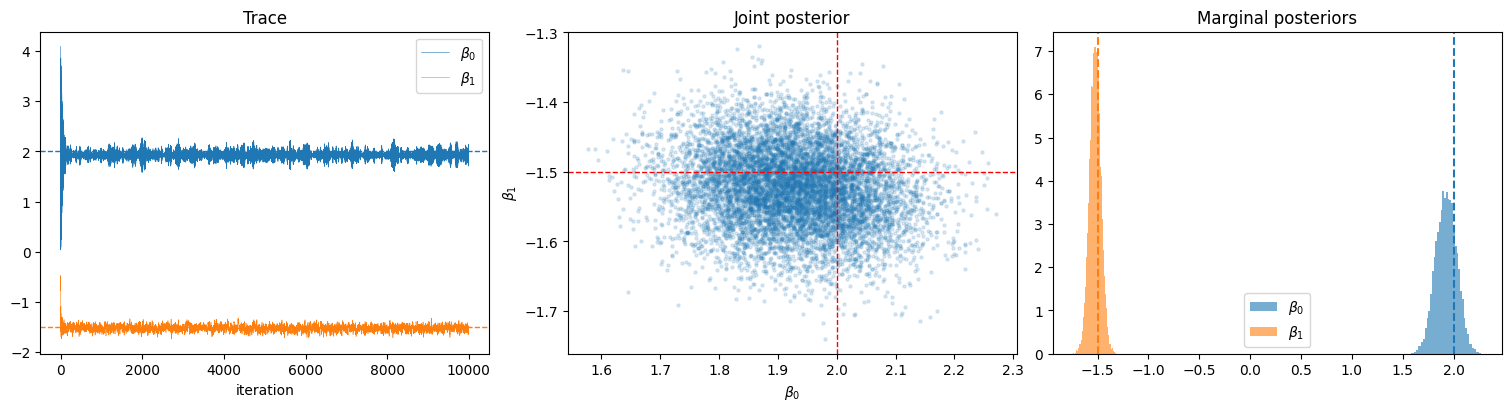

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

# トレース
for i, label in enumerate([r"$\beta_0$", r"$\beta_1$"]):
    axes[0].plot(trace_reg[:, i], linewidth=0.4, label=label)
axes[0].axhline(beta_true[0], color="C0", linestyle="--", linewidth=1)
axes[0].axhline(beta_true[1], color="C1", linestyle="--", linewidth=1)
axes[0].set_title("Trace")
axes[0].set_xlabel("iteration")
axes[0].legend()

# 同時分布
axes[1].scatter(posterior_reg[:, 0], posterior_reg[:, 1], alpha=0.15, s=5)
axes[1].axvline(beta_true[0], color="red", linestyle="--", linewidth=1)
axes[1].axhline(beta_true[1], color="red", linestyle="--", linewidth=1)
axes[1].set_xlabel(r"$\beta_0$")
axes[1].set_ylabel(r"$\beta_1$")
axes[1].set_title("Joint posterior")

# 周辺分布
axes[2].hist(posterior_reg[:, 0], bins=40, density=True, alpha=0.6, label=r"$\beta_0$")
axes[2].hist(posterior_reg[:, 1], bins=40, density=True, alpha=0.6, label=r"$\beta_1$")
axes[2].axvline(beta_true[0], color="C0", linestyle="--")
axes[2].axvline(beta_true[1], color="C1", linestyle="--")
axes[2].set_title("Marginal posteriors")
axes[2].legend()

plt.show()

### MH法との比較

同じ問題に対してランダムウォークMH法とHMCを比較する。

In [7]:
def random_walk_mh(
    U: callable,
    dim: int,
    n_samples: int = 10_000,
    burn_in: int = 1_000,
    step: float = 0.5,
    init: np.ndarray | None = None,
    seed: int = 42,
) -> tuple[np.ndarray, np.ndarray, float]:
    """ランダムウォークMH法（比較用）"""
    rng = np.random.default_rng(seed)
    if init is None:
        init = np.zeros(dim)

    samples = np.empty((n_samples, dim))
    theta = init.copy()
    logp = -U(theta)
    accepted = 0

    for t in range(n_samples):
        theta_prop = theta + rng.normal(0, step, dim)
        logp_prop = -U(theta_prop)

        if np.log(rng.random()) < logp_prop - logp:
            theta = theta_prop
            logp = logp_prop
            accepted += 1

        samples[t] = theta

    return samples[burn_in:], samples, accepted / n_samples


# 同じ問題でMH法を実行
posterior_mh, trace_mh, acc_rate_mh = random_walk_mh(
    U=U_normal,
    dim=2,
    n_samples=5_000,
    burn_in=500,
    step=0.5,
)

print(f"MH  acceptance rate = {acc_rate_mh:.3f}")
print(f"HMC acceptance rate = {acc_rate:.3f}")

MH  acceptance rate = 0.644
HMC acceptance rate = 0.994


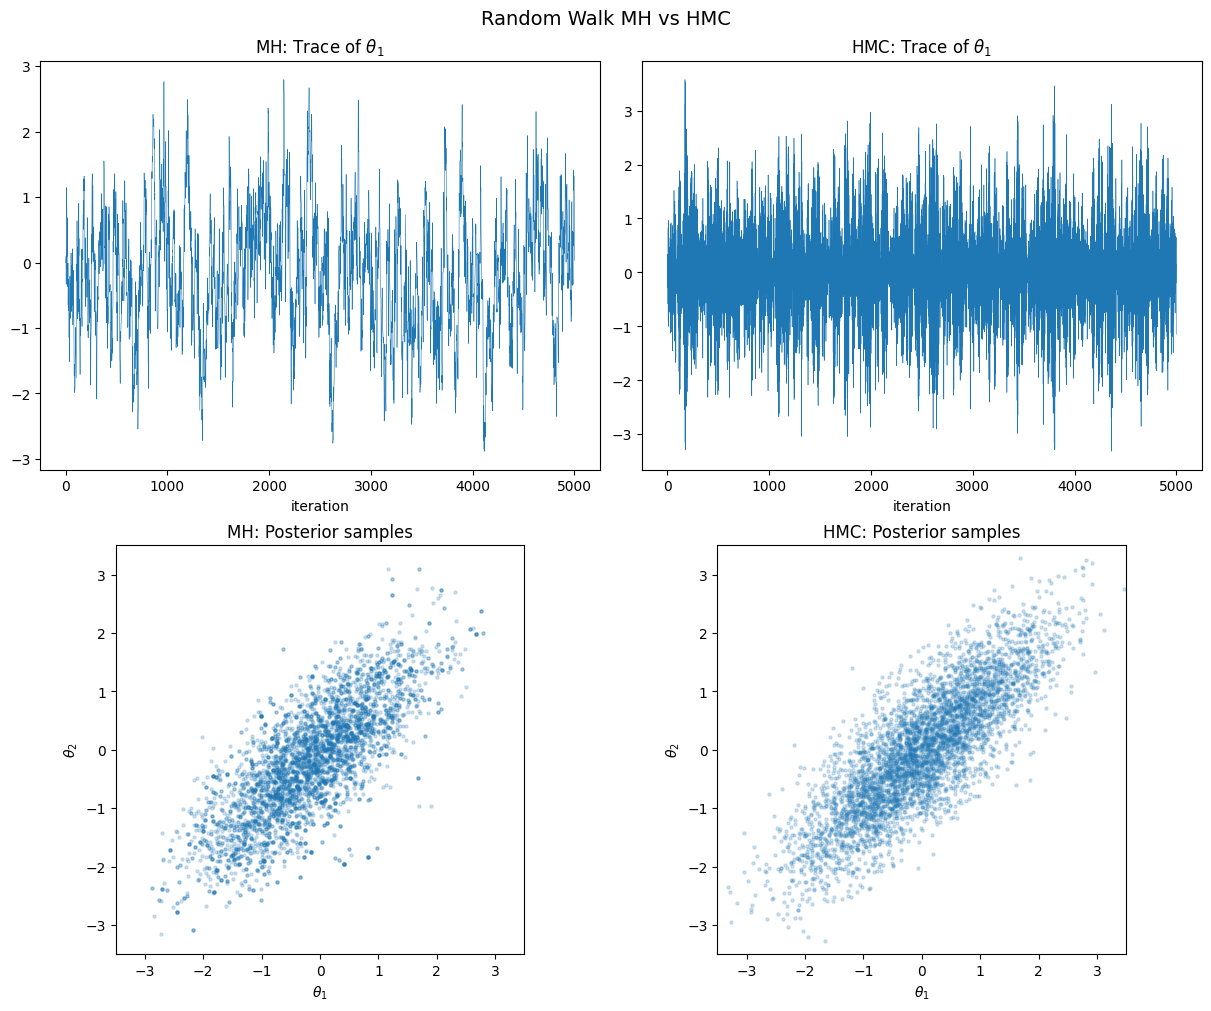

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# トレースの比較
axes[0, 0].plot(trace_mh[:, 0], linewidth=0.4)
axes[0, 0].set_title(r"MH: Trace of $\theta_1$")
axes[0, 0].set_xlabel("iteration")

axes[0, 1].plot(trace[:, 0], linewidth=0.4)
axes[0, 1].set_title(r"HMC: Trace of $\theta_1$")
axes[0, 1].set_xlabel("iteration")

# サンプルの比較
axes[1, 0].scatter(posterior_mh[:, 0], posterior_mh[:, 1], alpha=0.2, s=5)
axes[1, 0].set_title("MH: Posterior samples")
axes[1, 0].set_xlabel(r"$\theta_1$")
axes[1, 0].set_ylabel(r"$\theta_2$")
axes[1, 0].set_xlim(-3.5, 3.5)
axes[1, 0].set_ylim(-3.5, 3.5)
axes[1, 0].set_aspect("equal")

axes[1, 1].scatter(posterior[:, 0], posterior[:, 1], alpha=0.2, s=5)
axes[1, 1].set_title("HMC: Posterior samples")
axes[1, 1].set_xlabel(r"$\theta_1$")
axes[1, 1].set_ylabel(r"$\theta_2$")
axes[1, 1].set_xlim(-3.5, 3.5)
axes[1, 1].set_ylim(-3.5, 3.5)
axes[1, 1].set_aspect("equal")

fig.suptitle("Random Walk MH vs HMC", fontsize=14)
plt.show()

## ハイパーパラメータの影響

HMCの性能はステップサイズ $\varepsilon$ とステップ数 $L$ に大きく依存する。

| パラメータ | 小さすぎると | 大きすぎると |
|--------|------------|------------|
| $\varepsilon$（ステップサイズ） | 探索が遅い（MHと同様） | エネルギー保存が崩れ、受理率が低下 |
| $L$（ステップ数） | 提案が近すぎる | 計算コストが増大、U-turnする |

$\varepsilon$ と $L$ の調整は経験的に行う必要があり、この問題を自動化したのがNUTSである。

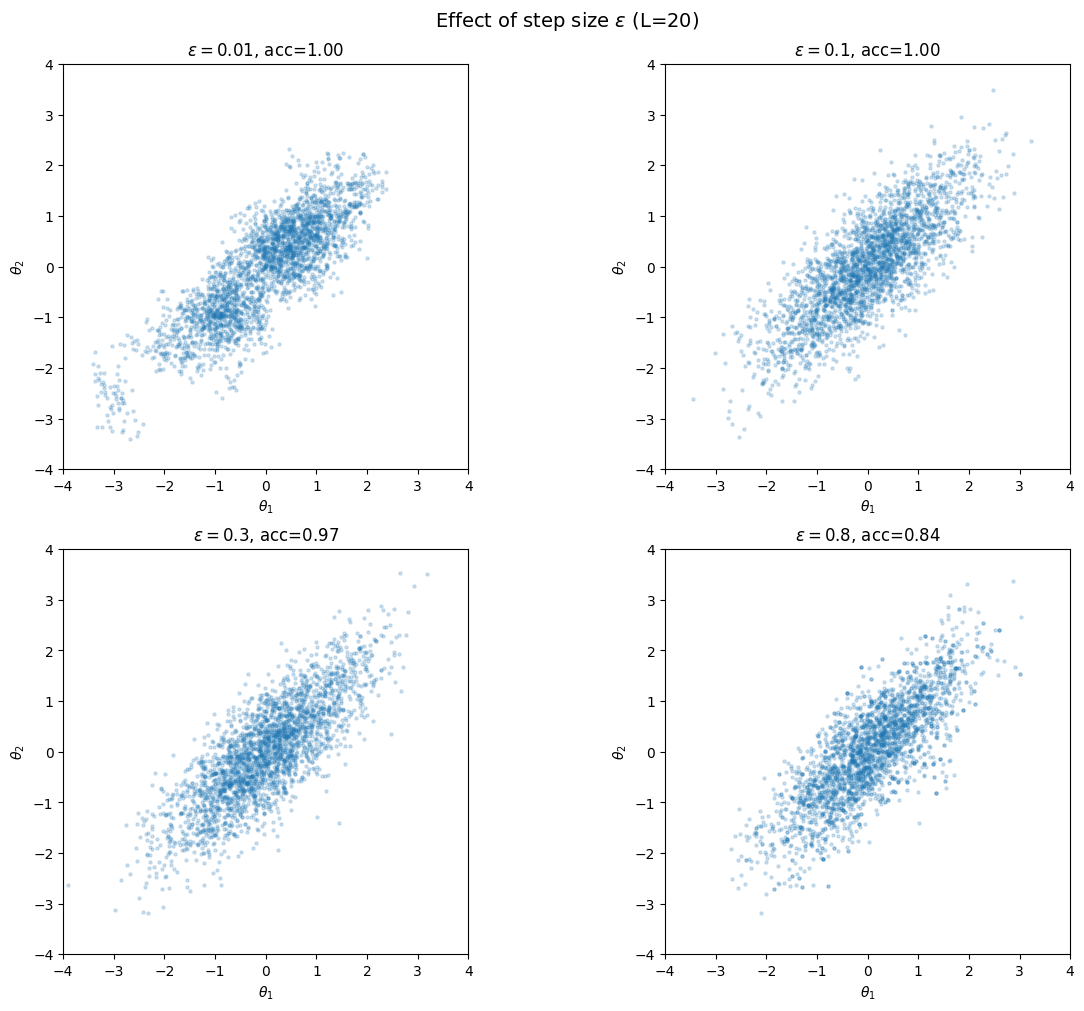

In [9]:
# ステップサイズの影響を可視化
epsilons = [0.01, 0.1, 0.3, 0.8]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

for ax, eps in zip(axes.flat, epsilons):
    post_eps, _, acc = hmc(
        U=U_normal,
        grad_U=grad_U_normal,
        dim=2,
        n_samples=3_000,
        burn_in=300,
        epsilon=eps,
        L=20,
    )
    ax.scatter(post_eps[:, 0], post_eps[:, 1], alpha=0.2, s=5)
    ax.set_title(f"$\\varepsilon={eps}$, acc={acc:.2f}")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect("equal")
    ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$")

fig.suptitle(r"Effect of step size $\varepsilon$ (L=20)", fontsize=14)
plt.show()

## NUTS: No-U-Turn Sampler

**NUTS (No-U-Turn Sampler)** はHoffman & Gelman (2014) が提案したHMCの拡張であり、HMCの2つのハイパーパラメータを自動調整する：

**ステップ数 $L$ の自動決定**

リープフロッグの軌跡が「U-turn」（元の位置に戻り始める）を検出した時点で自動的に停止する。具体的には、バイナリツリーを構築し、木の両端の状態 $(\theta^-, p^-)$ と $(\theta^+, p^+)$ が

$$
(\theta^+ - \theta^-) \cdot p^- < 0 \quad \text{or} \quad (\theta^+ - \theta^-) \cdot p^+ < 0
$$

を満たしたときに停止する（U-turn条件）。

**ステップサイズ $\varepsilon$ の自動調整**

ウォームアップ期間（burn-in）において、目標受理率（通常 0.65 前後）を達成するように dual averaging で $\varepsilon$ を適応的に調整する。

NUTSは現在のStan、PyMC、NumPyroなどの主要なベイズ推定フレームワークでデフォルトのサンプラーとして採用されている。

## HMCの限界と注意点

- **勾配が必要**: $\nabla_\theta \log p(\theta \mid y)$ が計算できないモデル（例：離散パラメータ）には適用できない。Stanなどでは自動微分（autodiff）で勾配を計算している
- **質量行列の調整**: パラメータ間のスケールが大きく異なる場合、質量行列 $M$ を事後分布の共分散行列の推定値に合わせることで性能が向上する
- **多峰分布**: HMCはエネルギー障壁を越えにくいため、多峰分布のサンプリングには注意が必要
- **次元の呼び**: 高次元でもMH法よりははるかに効率的だが、次元が非常に高い場合はそれでも困難になりうる

## まとめ

| | MH法（ランダムウォーク） | HMC | NUTS |
|---|---|---|---|
| 勾配の利用 | 不要 | 必要 | 必要 |
| 提案の効率 | 低い（ランダム） | 高い（勾配誘導） | 高い（勾配誘導） |
| ハイパーパラメータ | ステップサイズ | $\varepsilon$, $L$ | 自動調整 |
| 高次元での性能 | 劣化が激しい | 良好 | 良好 |
| 実装 | 簡単 | 中程度 | 複雑（フレームワーク推奨） |

## 参考文献

:::{card}

Neal, R. M. (2011). [MCMC using Hamiltonian dynamics](https://arxiv.org/abs/1206.1901). In *Handbook of Markov Chain Monte Carlo* (Chapter 5). Chapman & Hall/CRC.

HMCの包括的な解説。理論的背景から実装上の注意点まで詳細に述べられている

:::

:::{card}

Hoffman, M. D., & Gelman, A. (2014). [The No-U-Turn Sampler: Adaptively setting path lengths in Hamiltonian Monte Carlo](https://arxiv.org/abs/1111.4246). *Journal of Machine Learning Research*, 15, 1593–1623.

NUTSの原論文。HMCのハイパーパラメータ自動調整の標準的手法

:::

:::{card}

Betancourt, M. (2017). [A conceptual introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434). *arXiv preprint*.

微分幾何学の观点からHMCを解説した論文。概念的な理解に優れている

:::